# Assignment 3

## Objective of this assignment
The objective of this exercise is to become familiar with fitting decision trees and
making ROC curves in Python.


## ** Important: ** When handing in your homework:
+ Hand in the notebook (and nothing else) named as follows: StudentName1_snumber_StudentName2_snumber.ipynb
+ Provide clear and complete answers to the questions below under a separate header (not hidden somewhere in your source code), and make sure to explain your answers / motivate your choices. Add Markdown cells where necessary.
+ Source code, output graphs, derivations, etc., should be included in the notebook.
+ Hand-in: upload to Brightspace.
+ Include name, student number, assignment (especially in filenames)!
+ When working in pairs only one of you should upload the assignment, and report the name of your partner in your filename.
+ For problems or questions: use the Brightspace discussion board or email the student assistants.


## Advised Reading and Exercise Material
**The following reading material is recommended:**

Pang-Ning Tan, Michael Steinbach, and Vipin Kumar, Introduction to Data Mining, section 4.1-4.6, as well as the included article on ROC curves.


## 3.1 Decision trees

In this part of the exercise we will fit decision trees using the scikitlearn classifier
`sklearn.tree.DecisionTreeClassifier`. As a splitting criterion, the function uses
one of the following two impurity measures:

\begin{equation} \textrm{gdi}(t) = -\sum_{i=1}^C p(i|t)^2 \quad \text{       equivalent to Gini(t)} \end{equation}   

\begin{equation}
\textrm{deviance}(t) = -2\sum_{i=1}^C p(i|t) \log p(i|t) \quad \text{equivalent to Entropy(t)} 
\end{equation}

We will analyze the wine data we have used previously. The wine data set has the following attributes, all of which are continuous: 


| #             | Attribute     | Unit  |
| ------------- |:-------------| -----:|
|1 | Fixed acidity (tartaric) | g/dm$^3$ |
|2 | Volatile acidity (acetic) | g/dm$^3$ |
|3 | Citric acid | g/dm$^3$ |
|4 | Residual sugar | g/dm$^3$ |
|5 | Chlorides | g/dm$^3$ |
|6 | Free sulfur dioxide | mg/dm$^3$ |
|7 | Total sulfur dioxide | mg/dm$^3$ |
|8 | Density | g/cm$^3$ |
|9 | pH | pH |
|10 | Sulphates | g/dm$^3$ |
|11 | Alcohol | % vol. | 


#### 3.1.1
Load the wine data set `Data/wine.mat` using the `scipy.io` `loadmat` function. This contains the same data as used in the earlier assignment, but with outliers and the 12th attribute already removed. Create data matrix $X$, class vector $y$, and the vectors $attributeNames$ and $classNames$ with the data provided in the `wine.mat` file.  

   ** hints: **   
*The object in wine.mat is a dictionary. The attributes are stored in matrix $X$, the class in vector $y$. $y$ might be shaped as an array containing single element arrays. To flatten $y$, you can use `y.ravel()`. Attribute names and class names are stored in the attributeNames and classNames objects, which contain arrays, of which the first element contains the names. To get the names from those arrays, you can use list comprehension or for-loops. For more on list comprehension, check http://www.secnetix.de/olli/Python/list_comprehensions.hawk *



In [1]:
import numpy as np
from scipy.io import loadmat
from Toolbox.treeprint import tree_print
import graphviz 
from scipy.io import loadmat
from sklearn import model_selection, tree
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from scipy.stats import binom

#### To import graphviz please run the commands 'conda install graphviz' and 'conda install python-graphviz'. This allows for the printing of a nicer tree than the one used in treeprint ####

In [2]:
wine_data = loadmat('Data/wine.mat')

X = wine_data['X']
y = wine_data['y']
y = y.ravel()


attributeNames = [ x[0] for x in wine_data['attributeNames'][0] ]
classNames = [ x[0] for x in wine_data['classNames'].ravel() ]

#### 3.1.2
 (2 pts) Fit a decision tree to the wine data in order to estimate if the wine is red or white. Use the Gini (gdi) splitting criterion. Use `min_samples_split=100` for the stopping criterion. Explain what happens when you change the values of the parameter `min_samples_split`. After fitting the tree, visualize it with the tree_print function in `treeprint.py`. 

** hints: **   
*The `treeprint.py` file in the Toolbox folder contains some documentation on how to use it. Help documentation for the DecisionTreeClassifier function can be found at * http://scikit-learn.org/stable/modules/tree.html#classification  



         |->3  White
         |
      |->2 then if Sulphates =< 0.56: go to 3, else go to 4
      |  |
      |  |->4  White
      |
   |->1 then if Chlorides =< 0.05: go to 2, else go to 5
   |  |
   |  |  |->6  White
   |  |  |
   |  |->5 else if Sulphates =< 0.37: go to 6, else go to 7
   |     |
   |     |  |->8  White
   |     |  |
   |     |->7 else if Density =< 0.99: go to 8, else go to 9
   |        |
   |        |     |->11  White
   |        |     |
   |        |  |->10 then if Residual sugar =< 1.10: go to 11, else go to 12
   |        |  |  |
   |        |  |  |  |->13  Red
   |        |  |  |  |
   |        |  |  |->12 else if Density =< 0.99: go to 13, else go to 14
   |        |  |     |
   |        |  |     |  |->15  Red
   |        |  |     |  |
   |        |  |     |->14 else if Chlorides =< 0.05: go to 15, else go to 16
   |        |  |        |
   |        |  |        |  |->17  Red
   |        |  |        |  |
   |        |  |        |->16 else if Sulphates =< 0.45:

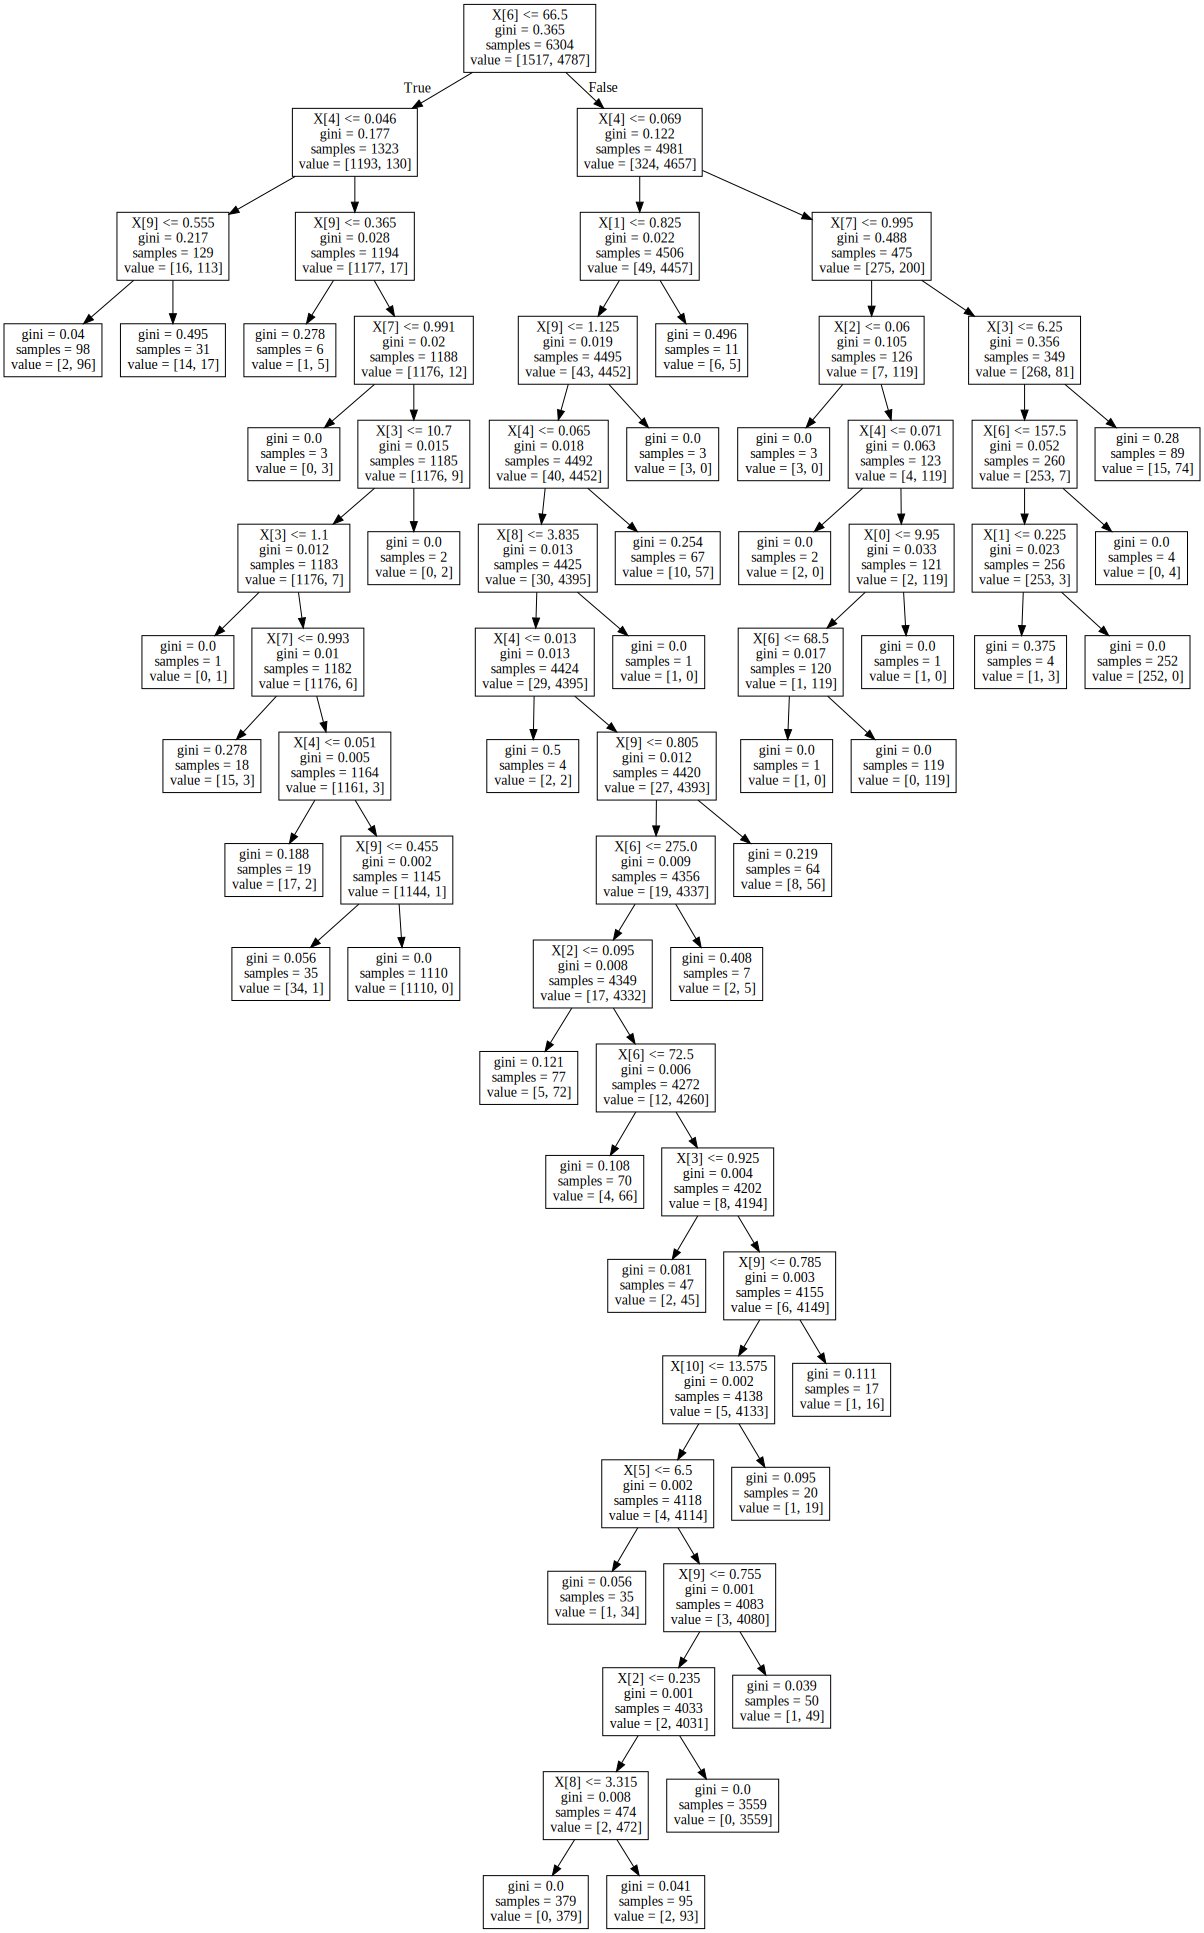

In [3]:
dtc = tree.DecisionTreeClassifier(criterion = "gini", min_samples_split=100)
dtc = dtc.fit(X,y)
tree_print(dtc, attributeNames, classNames)

dot_data = tree.export_graphviz(dtc, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

The value for min_samples_split determines how many datapoints need to be present in a branch of the tree, before a split is made. If the value is decreased (to e.g. 1) the tree will massively overfit every datapoint, because it will not capture similarity between data points.

#### 3.1.3

(0.5 pts) Show that a wine with the following attribute values would be classified as white by the tree fitted in 3.1.2. Which attributes are used to classify this wine?

| #             | Attribute     | Value  |
| ------------- |:-------------| -----:|
|1 | Fixed acidity (tartaric) | 6.9 g/dm$^3$ |
|2 | Volatile acidity (acetic) | 1.09 g/dm$^3$ |
|3 | Citric acid | 0.06 g/dm$^3$ |
|4 | Residual sugar | 2.1 g/dm$^3$ |
|5 | Chlorides | 0.0061 g/dm$^3$ |
|6 | Free sulfur dioxide | 12 mg/dm$^3$ |
|7 | Total sulfur dioxide | 31 mg/dm$^3$ |
|8 | Density | 0.99 g/cm$^3$ |
|9 | pH | 3.5 |
|10 | Sulphates | 0.64 g/dm$^3$ |
|11 | Alcohol | 12 % vol. | 

** hints: **
*If you don't know how to classify input values with a tree, see the help documentation for the DecisionTreeClassifier function on how to predict the label for a sample. *

In [4]:
sample = np.array([[6.9,1.09,0.06,2.1,0.0061,12,31,0.99,3.5,0.64,12]])
predi = dtc.predict(sample)
path = dtc.decision_path(sample)
leave = dtc.apply(sample)
print ('The classifier predicts the type of the wine to be ',classNames[predi[0]])
print ('The decision path:\n',path)
print('The terminal leave:\n',leave)

The classifier predicts the type of the wine to be  White
The decision path:
   (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (0, 4)	1
The terminal leave:
 [4]


The sample passes through nodes 0 (the root), 1, 2 and terminates at 4. These indices correspond to X[6], X[4] and X[9]. These attributes are total sulfur dioxide, chloride and sulphates respectively.

#### 3.1.4
(1 pts) Classify all the wines in the wine data set. What percentage of the wine data is classified correctly by the tree?



In [5]:
predictions = dtc.predict(X) == y
score = sum(predictions) / float(len(y))
print ('The manually computed accurarcy of the classifier is {:.2f} %.'.format(score*100))

score = dtc.score(X,y)
print ('The accurarcy of the classifier with the score function is {:.2f} %.'.format(score*100))

The manually computed accurarcy of the classifier is 98.68 %.
The accurarcy of the classifier with the score function is 98.68 %.


98,6% if the data is classified correctly.

## 3.2 Decision tree pruning using cross-validation

In this exercise we will use cross-validation to prune a decision tree. When applying cross-validation the observed data is split into training and test sets, i.e., `X_train`, `y_train` and `X_test` and `y_test`. We train the model on the training data and evaluate the performance of the trained model on the test data.

#### 3.2.1
(2 pts) Load the wine data set `Data/wine.mat` using the `scipy.io` `loadmat` function. Divide the data into a training and a test data set. Fit a decision tree to the training data using the Gini (`gdi`) splitting criterion.

Now, we want to find an optimally pruned decision tree by *modifying its maximum depth*. For different values of the parameter `depth` (from 2 to 20), 
+ first fit the decision tree
+ then compute the classification error on the training and test set (this is called holdout cross-validation)

When you've done this for `depth` values 2,...,20, plot the training and test classification error as a function of the tree depth in the same figure. This will show us what the optimal pruning depth is for the training set, but also how well this generalizes to a test set. 


** hints: **  
*Take a look at the module `sklearn.model_selection` and see how it can be used to partition the data into a training and a test set (holdout validation, `train_test_split()` function). Note that the package also contains functions to partition data for K-fold cross-validation. Some of the functions can ensure that both training and test sets have roughly the same class proportions.* 

What appears to be the optimal tree depth? Do you get the same result when you run your code again, generating a new random split between training and test data?


Depth =  2 Training Error:  0.04501288915328183 Testing Error:  0.04361617763679615
Depth =  3 Training Error:  0.025183422565932978 Testing Error:  0.03251387787470261
Depth =  4 Training Error:  0.016855046599246526 Testing Error:  0.016653449643140417
Depth =  5 Training Error:  0.01487209994051164 Testing Error:  0.015860428231562307
Depth =  6 Training Error:  0.013880626611144198 Testing Error:  0.016653449643140417
Depth =  7 Training Error:  0.013880626611144198 Testing Error:  0.016653449643140417
Depth =  8 Training Error:  0.013880626611144198 Testing Error:  0.016653449643140417
Depth =  9 Training Error:  0.013880626611144198 Testing Error:  0.016653449643140417
Depth =  10 Training Error:  0.013880626611144198 Testing Error:  0.016653449643140417
Depth =  11 Training Error:  0.013880626611144198 Testing Error:  0.016653449643140417
Depth =  12 Training Error:  0.013285742613523666 Testing Error:  0.016653449643140417
Depth =  13 Training Error:  0.013285742613523666 Testi

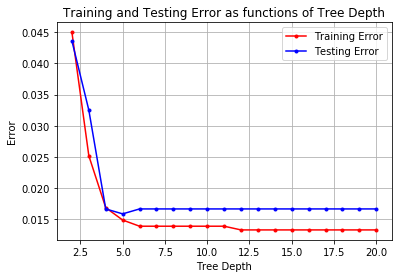

In [6]:
wine_data = loadmat('Data/wine.mat')

X = wine_data['X']
y = wine_data['y']
y = y.ravel()

attributeNames = [ x[0] for x in wine_data['attributeNames'][0] ]
classNames = [ x[0] for x in wine_data['classNames'].ravel() ]


### 3.2.1 ###


X_train, X_test, y_train, y_test = model_selection.train_test_split(X , y , test_size = 0.2) #, random_state=420

training_errors = []
testing_errors = []

for d in range(2,21):
    dtc = tree.DecisionTreeClassifier(criterion = "gini", min_samples_split=100, max_depth = d)
    dtc = dtc.fit(X_train,y_train)
    
    train_error = 1-dtc.score(X_train,y_train)
    training_errors.append(train_error)
    
    test_error = 1-dtc.score(X_test,y_test)
    testing_errors.append(test_error)
    
    print ('Depth = ', d, 'Training Error: ', train_error, 'Testing Error: ', test_error)
    
    
plt.plot(range(2,21) , training_errors, '.-r', label = "Training Error")
plt.plot(range(2,21) , testing_errors, '.-b', label = "Testing Error")
plt.xlabel('Tree Depth')
plt.ylabel('Error')
plt.legend()
plt.title('Training and Testing Error as functions of Tree Depth')
plt.grid()
plt.show()

No, the generated trees vary substantially. This has two reasons: First, the random split of the dataset into training and testing subsets is, as the word suggests, random every time. Sometimes, the testing data and the training data do not match very well. Using the random_state parameter to set a seed partially alleviates this issue. Second, every time a tree is generated, it is slightly different. As of now, a tree depth of 5 seems to be optimal. Interestingly enough, greater tree depths could lead to a bit of overfitting, which might be why the testing error is larger for greater tree depths.

#### 3.2.2
(1.5 pts) Repeat the exercise above, using 10-fold cross-validation. K-fold cross-validation works by splitting X into K partitions of equal length. Then in each fold, you choose K-1 partitions as the training set and the remaining partition as the test set. Every partition gets a turn being a test set. For a very nice simple explanation of how (and why) K-fold works, check out http://www.dummies.com/programming/big-data/data-science/resorting-cross-validation-machine-learning/


For each fold, fit a decision tree on the training set and evaluate its performance on the test set. Finally, compute the average classification errors on the test- and training sets across the 10 cross-validation folds and plot them as a function of the tree depth.

** hints: **
*This time the `KFold()` function from the module `sklearn.model_selection` can be used to partition the data into the 10 training and test partitions. Check out http://scikit-learn.org/stable/modules/cross_validation.html#k-fold for an example of how to acces the indices for the training set and the test set in each fold. Those indices can then be used to create the training and test set, e.g. `X_train = X[train_indices]`*
 

What appears to be the optimal tree depth? Do you get the same result when you run your code again, generating a new random split between training and test data? How about 100-fold cross-validation?


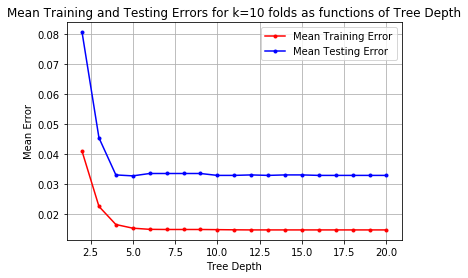

In [7]:
### 3.2.2 ###

mean_training_errors = []
mean_testing_errors = []

K = 10
CV = model_selection.KFold(n_splits = K)

for d in range(2,21):
    
    training_errors = []
    testing_errors = []
    
    for train_index, test_index in CV.split(X):
        X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
    
        dtc = tree.DecisionTreeClassifier(criterion = "gini", min_samples_split=100, max_depth = d)
        dtc = dtc.fit(X_train,y_train)
    
        train_error = 1-dtc.score(X_train,y_train)
        training_errors.append(train_error)
        
        test_error = 1-dtc.score(X_test,y_test)
        testing_errors.append(test_error)
    
    mean_training_errors.append(np.mean(training_errors))
    mean_testing_errors.append(np.mean(testing_errors))
    
    
plt.plot(range(2,21) , mean_training_errors, '.-r', label = "Mean Training Error")
plt.plot(range(2,21) , mean_testing_errors, '.-b', label = "Mean Testing Error")
plt.xlabel('Tree Depth')
plt.ylabel('Mean Error')
plt.legend()
plt.title('Mean Training and Testing Errors for k=10 folds as functions of Tree Depth') 
plt.grid()
plt.show()

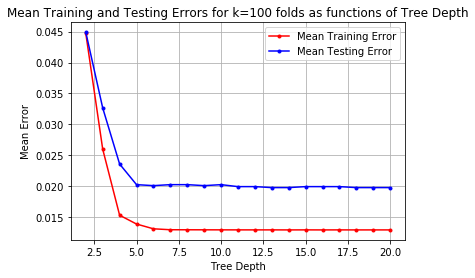

In [8]:
mean_training_errors = []
mean_testing_errors = []

K = 100
CV = model_selection.KFold(n_splits = K)

for d in range(2,21):
    
    training_errors = []
    testing_errors = []
    
    for train_index, test_index in CV.split(X):
        X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
    
        dtc = tree.DecisionTreeClassifier(criterion = "gini", min_samples_split=100, max_depth = d)
        dtc = dtc.fit(X_train,y_train)
    
        train_error = 1-dtc.score(X_train,y_train)
        training_errors.append(train_error)
        
        test_error = 1-dtc.score(X_test,y_test)
        testing_errors.append(test_error)
    
    mean_training_errors.append(np.mean(training_errors))
    mean_testing_errors.append(np.mean(testing_errors))
    
    
plt.plot(range(2,21) , mean_training_errors, '.-r', label = "Mean Training Error")
plt.plot(range(2,21) , mean_testing_errors, '.-b', label = "Mean Testing Error")
plt.xlabel('Tree Depth')
plt.ylabel('Mean Error')
plt.legend()
plt.title('Mean Training and Testing Errors for k=100 folds as functions of Tree Depth') 
plt.grid()
plt.show()

Yes, the same results (or at least very similar ones) are obtained when the code is ran multiple times. This is thanks to how kfold crossvalidation works: each data point is used once for testing and k-1 for training, and the error is averaged across all results for each fold. Thus, where the random split occured does not matter. For 100 folds, the classifier is almost twice as accurate and the error is only half of what it was for 10 folds.

 ## 3.3 ROC curves, AUC scores, and the sign test

In this exercise we will use ROC curves and the sign test to compare classifiers. Study the lecture slides and the paper 'ROC Graphs: Notes and Practical Considerations for Researchers' by Tom Fawcett included with the homework assignment (ROC101.pdf). It describes all you need to know (and much, much more..) about ROC curves. The method explained for computing the area under the curve is unnecessarily complicated. A simpler formula is:
$$
    \mbox{AUC} = {1 \over m n} \sum_{i=1}^m \sum_{j=1}^n \mathbf{\large 1}_{p_i > p_j} \: .
   $$
Here $i$ runs over all $m$ data points with true label 1, and $j$ runs over all $n$ data points with true label $0$; $p_i$ and $p_j$ denote the probability score assigned by the classifier to data point $i$ and $j$, respectively. $\mathbf{\large 1}$ is the indicator function: it outputs $1$ if the condition (here $p_i > p_j$) is satisfied and $0$ otherwise. *Simply put: this formula computes how often the probability of a data point with true label 1 is higher than the probability of data points with true label 0. This is then divided by the total number of comparisons between probabilities.*
    

#### 3.3.1
(0.25 pts) To make sure you understand how ROC works, you can make an ROC curve and calculate the AUC (on paper) with the following data:

`
labels = [0,0,0,1,0,1,1,0,1,1]
classifier_probs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
`
    
What's the AUC you calculated? Do you think this classifier works well?


The AUC is 0.84. I think the classifier works reasonably well, much better than guessing (0.5) at least. However, it is certainly not optimal and could probably be improved.

#### 3.3.2
  Load the file `Data/classprobs.xls` using the Pandas `read_excel` function. Inspect the data and cast it to an array with the `as_matrix` function. The first column gives the true class label (either 0 or 1). The second and third column give the probabilistic scores for two different classifiers. The higher this probability, the more certain the classifier is that the example belongs to class 1 (instead of class 0).


In [9]:
xlsx = pd.ExcelFile('Data/classprobs.xls')
doc = pd.read_excel(xlsx, 'Sheet1', header = None, names = ['TrueClass','Classifier1','Classifier2'])
data = doc.values

true_class = data[:,0]
pred1 = data[:,1]
pred2 = data[:,2]

*Double click to type your elaboration for question 3.3.2 here*

The task 3.3.2 does not specify what to elaborate.

#### 3.3.3
(1 pts) Calculate the ROC curves for both of the classifiers and plot them in the same plot. Also plot a dashed line on the diagonal to represent random guessing in the same figure. Interpret the obtained results. Do both classifiers perform better than random guessing?

** hints: **  
*The function `sklearn.metrics.roc_curve` can be used for computing the FP and TP rates. You can then plot them using the `matplotlib.pyplot` `plot` function. Check the documentation on how to plot a dashed line. Remember to include a legend!* 

**An extra tip: the sign test example below includes a figure with dashed lines and a legend...**
 

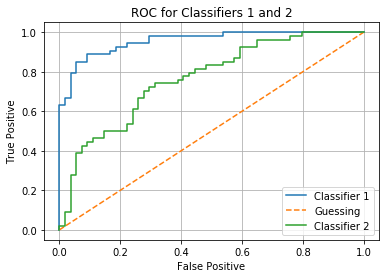

In [10]:
FP1, TP1, thresh1 = roc_curve(true_class, pred1)
FP2, TP2, thresh2 = roc_curve(true_class, pred2)

plt.plot(FP1, TP1, label = "Classifier 1")
plt.plot([0,1], [0,1], ls="--", label = "Guessing")
plt.plot(FP2, TP2, label = "Classifier 2")
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC for Classifiers 1 and 2')
plt.legend()
plt.grid()
plt.show()

Yes, as you can see on the graph, the area under the curve for both classifiers is larger than the area for simply guessing. Thus, they outperform guessing.

#### 3.3.4
(0.5 pts) Compute the AUC scores (area under the curve) of both classifiers using the formula given above. Write your own code for this calculation. Do the AUC scores indicate that the classifiers are performing better than this baseline?




 

In [11]:
m = 0
auc1 = 0

for i in range (len(true_class)):
    if true_class[i] == 1:
        m += 1
        for j in range (len(true_class)):
            if true_class[j] == 0:
                if pred1[i] > pred1[j]:
                    auc1 += 1
                    
n = len(true_class) - m
auc1 = float(auc1) / float(m*n)                    

auc2 = 0

for i in range (len(true_class)):
    if true_class[i] == 1:
        for j in range (len(true_class)):
            if true_class[j] == 0:
                if pred2[i] > pred2[j]:
                    auc2 += 1
                    
auc2 = float(auc2) / float(m*n)      

print (auc1 == roc_auc_score(true_class, pred1), auc2 == roc_auc_score(true_class, pred2))
print ('AUC Classifier 1 = {:.3f}, AUC Classifier 2 = {:.3f}, AUC Guessing = 0.5'.format(auc1,auc2))

True True
AUC Classifier 1 = 0.956, AUC Classifier 2 = 0.765, AUC Guessing = 0.5


Yes, both classifiers have an AUC of over 0.5, which makes them better than the guessing baseline. The first classifier has an area of 0.956, which is pretty close to the theoretical limit of 1. It is hence much better than either guessing, or classifier 2 with an area of 0.765


#### 3.3.5
(0.25 pts) Using a threshold of 0.5, translate the probability scores to predicted class labels, and compute the accuracy for each of the classifiers.

In [12]:
predictions1 = []
for i in range (len(pred1)):
    if pred1[i] >= 0.5:
        predictions1.append(1)
    else:
        predictions1.append(0)
        
        
predictions2 = []
for i in range (len(pred2)):
    if pred2[i] >= 0.5:
        predictions2.append(1)
    else:
        predictions2.append(0)        


matches_c1 = 0        
for i in range (len(pred1)):
    if predictions1[i]==true_class[i]:
        matches_c1 +=1 
        
matches_c2 = 0        
for i in range (len(pred2)):
    if predictions2[i]==true_class[i]:
        matches_c2 +=1         
        
                
accuracy_c1 = float(matches_c1) / len(pred1)       
accuracy_c2 = float(matches_c2) / len(pred2)

print ('Accuracy for Classifier 1 = {:.3f} ; Accuracy for Classifier 2 = {:.3f}'.format(accuracy_c1,accuracy_c2))

Accuracy for Classifier 1 = 0.861 ; Accuracy for Classifier 2 = 0.694


The first classifer is much more accurate (86,1%) than the second (69,4%).

#### 3.3.6
(1 pts) Create the 2x2 table of wrong and correct classifications by the first and the second classifier, like in the lecture slides (lecture on model evaluation, part on the sign test). Perform a sign test to test whether the performance of the two classifiers is significantly different at a significance level of 0.05. **If you are not familiar with sign testing, you can read the example provided below.**


** hints: **  
*As explained in the lecture slides, the sign test is a binomial test on the lower-left ($N_{1<2}$) and upper-right ($N_{1>2}$) elements of the cross table. Unlike in the lecture slides, here you need to perform a two-sided test: $$\textrm{p-value} = P(W \leq \min(N_{1<2},N_{1>2}) \textrm{ or } W \geq  \max(N_{1<2},N_{1>2})$$
The function `scipy.stats.binom.cdf` can be used to compute the cumulative density of the binomial distribution.
For more information on the sign test, see the included paper by Salzberg (signtest.pdf, in particular section 3.1).*

In [13]:
a = np.array([0,0,0,0]).reshape(2,2)

for i in range(len(true_class)):
    
    if  (true_class[i] == predictions1[i]) & (true_class[i] == predictions2[i]) :
        a[0,0]+=1
     
    if  (true_class[i] == predictions1[i]) & (true_class[i] != predictions2[i]) :
        a[0,1]+=1
        
    if  (true_class[i] != predictions1[i]) & (true_class[i] == predictions2[i]) :
        a[1,0]+=1
        
    if  (true_class[i] != predictions1[i]) & (true_class[i] != predictions2[i]) :
        a[1,1]+=1    
        
N = a[0,1] + a[1,0]        
b = binom(N,0.5)        
p_value = b.cdf(min(a[0,1],a[1,0])) + (1-b.cdf(max(a[0,1],a[1,0])-1))
print('The p-value is {:.3f}'.format(p_value))

The p-value is 0.003


The two-sided sign tests yields a p value of 0.003. This result is extremely unlikely (3 in 1000), if we assume the two classifiers to have the same performance. This null hypothesis should thus be rejected, since there is significant evidence for difference in performance.

## Example two-sided sign test

Imagine you have a lucky coin, that you are certain does not result in heads 50% of the times you flip it. However, you friend (lets call him *zero_hypothesis*) claims that your coin is just like his random coin. To verify whether this is true, you decide to compare the performance (you are a scientist after all) of your lucky coin resulting in heads to the performance of the random coin resulting in heads with a sign test. How do you do this?

First, you collect data. Assume you both used your coin during 23 bets. During those 23 bets, you both flip your respective coins. It was determined that if one of you flipped head while the other didn't, that person won the bet, and the other person lost. If you both got the same outcome, neither of you won. 1 stands for head, and 0 for tails. These were your results:

In [14]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

#results
lucky_coin = np.array([1,1,1,0,1,1,1,1,1,0,1,1,1,1,0,1,1,0,1,1,1,0,1])
random_coin= np.array([0,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1,0,0,0,0,0,0])


Now you calculate how often in any pair of outcomes one coin *won*, i.e. one coin flipped to head while the other flipped to tails.

In [15]:
N_l = sum((lucky_coin == 1) & (random_coin == 0)) #how often your lucky coin won
N_r = sum((lucky_coin == 0) & (random_coin == 1)) #how often the random coin won
N = N_l + N_r #how often one coin was a winner
print('The lucky coin won {} times, while the random won {} times.'.format(N_l,N_r))

The lucky coin won 12 times, while the random won 3 times.


You observed 15 times that one coin won. If both coins resulted in heads 50% of the time, like *zero_hypothesis* stated, you'd expect that both coins have 50% chance of being the winner. So the probability distributions for both N_l and N_r should look something like this, assuming that *zero_hypothesis* is right:

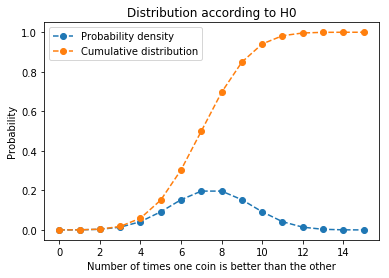

In [16]:
b = binom(N,0.5) #N=observations of inequality, p=prob of one coin being better, which is 0.5 according to your H0
plt.plot(b.pmf(range(N+1)), '--o',label = 'Probability density')
plt.plot(b.cdf(range(N+1)), '--o',label = 'Cumulative distribution')
plt.legend()
plt.xlabel('Number of times one coin is better than the other')
plt.ylabel('Probability')
plt.title('Distribution according to H0')
plt.show()

(Of course this is a discrete probability function, so you're not interested in values between integers.)

As you can see, according to *zero_hypothesis*, 7 and 8 are the most likely values for both N_l and N_r. But this is not what you observed in your data. To conclude that *H0* is false, you need to show that your outcome is unlikely under the assumption that *H0* is true: the values you observed are so extreme that these values or more extreme values occur less than 5% of the time (*p-value < 0.05*). So how unlikely is it that one coin is better 12 times or more, and the other is better 3 times or less?

It's the sum of the values of the probability density function (pdf or pmf in the python doc) at  0,1,2 and 3, plus the sum of the values of the pdf at 12,13,14 and 15. 

This is equal to the value of the cumulative distribution function (cdf) at 3, plus 1 minus the value of cdf at 11 (since `1-cdf(11)` represents the probability of observing 12 or bigger).

In [17]:
p_value = b.cdf(min(N_r,N_l)) + (1-b.cdf(max(N_r,N_l)-1))
print('The p-value is {:.3f}'.format(p_value))

The p-value is 0.035


So your observations are very unlikely if *zero_hypothesis* is right. By statistical theory, you can now say that you have significant reason to reject their opinion. Now the hardest part of statistics: convincing your non-scientist friends.